In [1]:
!pip install tensorflow
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir=None, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)

        if mask_dir:
            self.mask_filenames = os.listdir(mask_dir)
            assert len(self.image_filenames) == len(self.mask_filenames), "Number of images and masks must match."
        else:
            self.mask_filenames = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('DataGenerator object is out of range')
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_images):
        X = np.empty((self.batch_size, *self.target_size, 3))  # Satellite images with 3 channels (RGB)
        if self.mask_dir:
            y = np.empty((self.batch_size, *self.target_size, 1))  # Masks converted to 1 channel
        else:
            y = None

        for i, image_name in enumerate(batch_images):
            # Load and preprocess satellite image (RGB)
            img_path = os.path.join(self.image_dir, image_name)
            image = load_img(img_path, target_size=self.target_size)  # Default is RGB
            X[i,] = img_to_array(image) / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask image (convert RGB to grayscale)
            if self.mask_dir:
                mask_name = image_name.replace('_sat.jpg', '_mask.png')
                mask_path = os.path.join(self.mask_dir, mask_name)
                mask = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')  # Load mask as grayscale
                y[i,] = img_to_array(mask) / 255.0

        return X, y

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
train_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/train_resize/satellite_resize',
    mask_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/train_resize/mask_resize',
    batch_size=32,
    target_size=(256, 256),
    shuffle=True
)

val_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/validation_resize/validation_satellite_resize',
    mask_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/validation_resize/validation_mask_resize',
    batch_size=32,
    target_size=(256, 256),
    shuffle=False
)

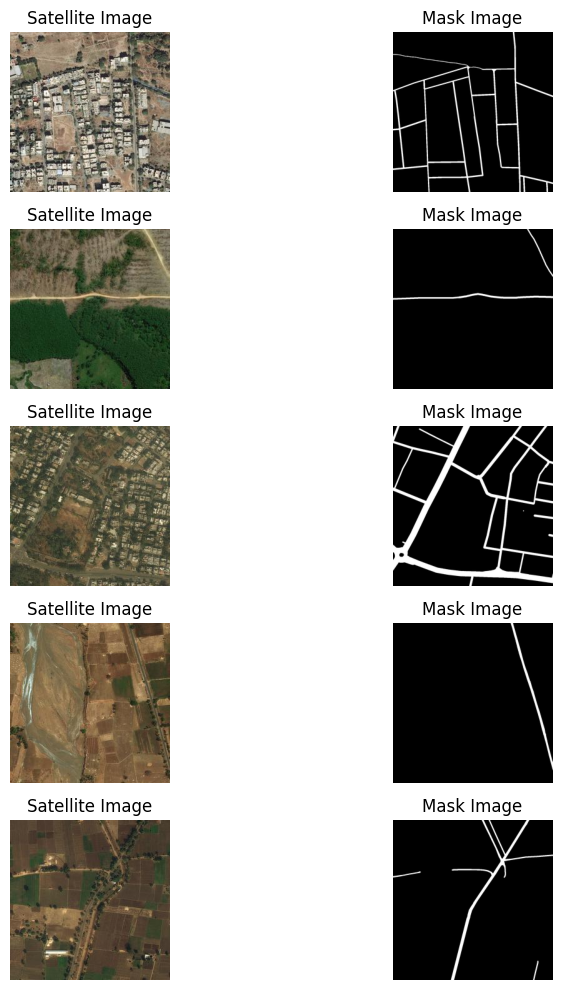

In [ ]:
import matplotlib.pyplot as plt

satellite_images, masks = train_gen[0]  # Get first bactch

num_images = 5

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

for i in range(num_images):
    # Display satellite image
    axes[i, 0].imshow(satellite_images[i])
    axes[i, 0].set_title('Satellite Image')
    axes[i, 0].axis('off')

    # Display mask image
    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Squeeze to remove single-dimensional entries
    axes[i, 1].set_title('Mask Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
total_batches = len(train_gen)
print(f"Total batches in train_gen: {total_batches}")

Total batches in train_gen: 175


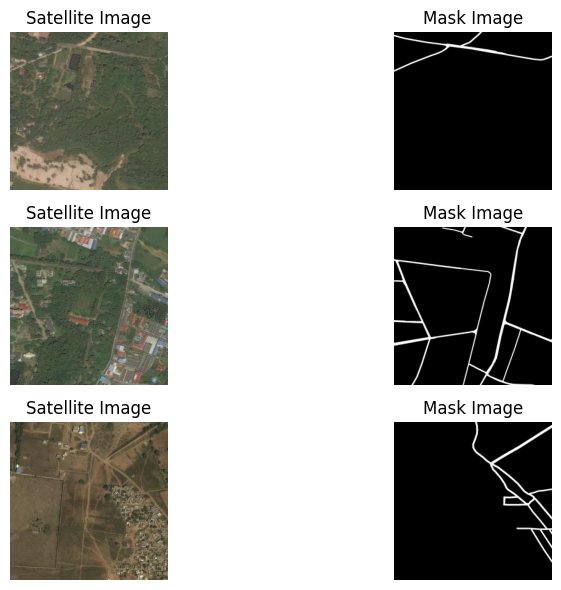

In [ ]:
import matplotlib.pyplot as plt

satellite_images, masks = val_gen[0]  # Get the first batch

num_images = 3

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

for i in range(num_images):
    axes[i, 0].imshow(satellite_images[i])
    axes[i, 0].set_title('Satellite Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Squeeze to remove single-dimensional entries
    axes[i, 1].set_title('Mask Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
total_batches = len(val_gen)
print(f"Total batches in val_gen: {total_batches}")

Total batches in val_gen: 19


In [ ]:
import os
import shutil
import random

def create_test_dataset(source_image_dir, dest_image_dir, num_images=100):
    """
    Creates a test dataset by randomly selecting images from the train dataset.
    Only copies satellite images, excluding masks.

    Args:
        source_image_dir: Path to the source directory containing training images.
        dest_image_dir: Path to the destination directory for test images.
        num_images: Number of images to select for the test dataset.
    """
    # Create destination directory if it doesn't exist
    os.makedirs(dest_image_dir, exist_ok=True)

    # Get a list of image filenames from the source directory
    image_filenames = os.listdir(source_image_dir)

    # Randomly select a subset of images
    selected_images = random.sample(image_filenames, num_images)

    # Copy selected images to the destination directory
    for image_filename in selected_images:
        source_image_path = os.path.join(source_image_dir, image_filename)
        dest_image_path = os.path.join(dest_image_dir, image_filename)
        shutil.copy(source_image_path, dest_image_path)

# ✅ Use a writable destination directory
source_image_dir = '/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/train_resize/satellite_resize'
dest_image_dir = '/content/drive/MyDrive/DL-Project/test_images'

create_test_dataset(source_image_dir, dest_image_dir, num_images=100)


In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/DL-Project/test_images',  # Specify the 'images' subdirectory
    batch_size=32,  # Or adjust the batch size
    target_size=(256, 256),
    shuffle=False
)

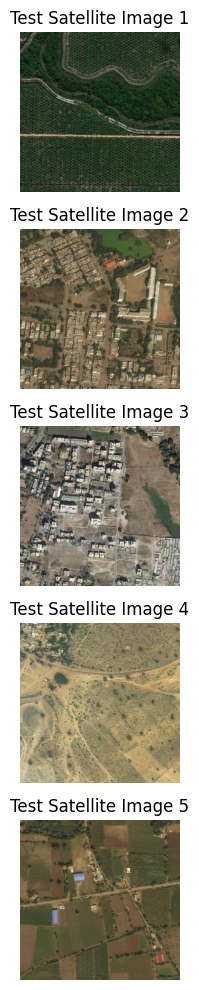

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_gen yields (images, masks), you can access the images like this:
test_images, _ = test_gen[1]  # Ignore masks for visualization

num_images = 5

fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 2))

for i in range(num_images):
    # Display satellite image
    axes[i].imshow(test_images[i])  # Access the individual image
    axes[i].set_title(f'Test Satellite Image {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, UpSampling2D, BatchNormalization, Activation,
    Add, concatenate, Lambda
)
from tensorflow.keras.callbacks import CSVLogger
import tensorflow as tf

# ResUNet building blocks
def conv_block(feature_map):
    conv_1 = Conv2D(64, (3, 3), padding='same')(feature_map)
    bn = BatchNormalization()(conv_1)
    relu = Activation('relu')(bn)
    conv_2 = Conv2D(64, (3, 3), padding='same')(relu)
    res_conn = Conv2D(64, (1, 1), padding='same')(feature_map)
    res_conn = BatchNormalization()(res_conn)
    addition = Add()([res_conn, conv_2])
    return addition

def res_block(feature_map, conv_filter, stride):
    bn_1 = BatchNormalization()(feature_map)
    relu_1 = Activation('relu')(bn_1)
    conv_1 = Conv2D(conv_filter, (3, 3), strides=stride[0], padding='same')(relu_1)
    bn_2 = BatchNormalization()(conv_1)
    relu_2 = Activation('relu')(bn_2)
    conv_2 = Conv2D(conv_filter, (3, 3), strides=stride[1], padding='same')(relu_2)
    res_conn = Conv2D(conv_filter, (1, 1), strides=stride[0], padding='same')(feature_map)
    res_conn = BatchNormalization()(res_conn)
    addition = Add()([res_conn, conv_2])
    return addition

def encoder(feature_map):
    to_decoder = []
    path = conv_block(feature_map)
    to_decoder.append(path)
    path = res_block(path, 128, [(2, 2), (1, 1)])
    to_decoder.append(path)
    path = res_block(path, 256, [(2, 2), (1, 1)])
    to_decoder.append(path)
    return to_decoder

def decoder(feature_map, from_encoder):
    main_path = UpSampling2D((2, 2), interpolation='bilinear')(feature_map)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, 256, [(1, 1), (1, 1)])

    main_path = UpSampling2D((2, 2), interpolation='bilinear')(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, 128, [(1, 1), (1, 1)])

    main_path = UpSampling2D((2, 2), interpolation='bilinear')(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, 64, [(1, 1), (1, 1)])

    return main_path

def ResUNet(inputshape=(256, 256, 3)):
    model_input = Input(shape=inputshape)
    x = Lambda(lambda x: x / 255.0)(model_input)
    enc = encoder(x)
    bottleneck = res_block(enc[2], 512, [(2, 2), (1, 1)])
    dec = decoder(bottleneck, enc)
    output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(dec)
    return Model(model_input, output)

# Initialize ResUNet model
model = ResUNet((256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Set up Google Drive logging path
log_dir = '/content/drive/MyDrive/DL-Project'
os.makedirs(log_dir, exist_ok=True)

# CSVLogger for training history
csv_logger = CSVLogger(os.path.join(log_dir, 'training_log_resunet.csv'))

# Assuming train_gen and val_gen are already defined
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=10,
    validation_data=val_gen,
    validation_steps=10,
    callbacks=[csv_logger]
)

# Save the model
model_save_path = os.path.join(log_dir, 'resunet_segmentation_model.h5')
model.save(model_save_path)

print(f"Model saved at: {model_save_path}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        256 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ add[0][0]         │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      8,320 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][

 Total params: 8,233,025 (31.41 MB)

 Trainable params: 8,223,809 (31.37 MB)

 Non-trainable params: 9,216 (36.00 KB)

NameError: name 'train_gen' is not defined

In [ ]:
import os
model_save_path = os.path.join(log_dir, 'resunet_segmentation_model.h5')
model.save(model_save_path)

print(f"Model saved at: {model_save_path}")

NameError: name 'log_dir' is not defined

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('resunet_segmentation_model.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'resunet_segmentation_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, UpSampling2D, BatchNormalization, Activation,
    Add, concatenate, Lambda
)
from tensorflow.keras.callbacks import CSVLogger
import tensorflow as tf

# ResUNet building blocks
def conv_block(feature_map):
    conv_1 = Conv2D(64, (3, 3), padding='same')(feature_map)
    bn = BatchNormalization()(conv_1)
    relu = Activation('relu')(bn)
    conv_2 = Conv2D(64, (3, 3), padding='same')(relu)
    res_conn = Conv2D(64, (1, 1), padding='same')(feature_map)
    res_conn = BatchNormalization()(res_conn)
    addition = Add()([res_conn, conv_2])
    return addition

def res_block(feature_map, conv_filter, stride):
    bn_1 = BatchNormalization()(feature_map)
    relu_1 = Activation('relu')(bn_1)
    conv_1 = Conv2D(conv_filter, (3, 3), strides=stride[0], padding='same')(relu_1)
    bn_2 = BatchNormalization()(conv_1)
    relu_2 = Activation('relu')(bn_2)
    conv_2 = Conv2D(conv_filter, (3, 3), strides=stride[1], padding='same')(relu_2)
    res_conn = Conv2D(conv_filter, (1, 1), strides=stride[0], padding='same')(feature_map)
    res_conn = BatchNormalization()(res_conn)
    addition = Add()([res_conn, conv_2])
    return addition

def encoder(feature_map):
    to_decoder = []
    path = conv_block(feature_map)
    to_decoder.append(path)
    path = res_block(path, 128, [(2, 2), (1, 1)])
    to_decoder.append(path)
    path = res_block(path, 256, [(2, 2), (1, 1)])
    to_decoder.append(path)
    return to_decoder

def decoder(feature_map, from_encoder):
    main_path = UpSampling2D((2, 2), interpolation='bilinear')(feature_map)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, 256, [(1, 1), (1, 1)])

    main_path = UpSampling2D((2, 2), interpolation='bilinear')(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, 128, [(1, 1), (1, 1)])

    main_path = UpSampling2D((2, 2), interpolation='bilinear')(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, 64, [(1, 1), (1, 1)])

    return main_path

def ResUNet(inputshape=(256, 256, 3)):
    model_input = Input(shape=inputshape)
    x = Lambda(lambda x: x / 255.0)(model_input)
    enc = encoder(x)
    bottleneck = res_block(enc[2], 512, [(2, 2), (1, 1)])
    dec = decoder(bottleneck, enc)
    output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(dec)
    return Model(model_input, output)

# Initialize ResUNet model
model = ResUNet((256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Set up Google Drive logging path
log_dir = '/content/drive/MyDrive/DL-Project'
os.makedirs(log_dir, exist_ok=True)

# CSVLogger for training history
csv_logger = CSVLogger(os.path.join(log_dir, 'training_log_resunet.csv'))

# Assuming train_gen and val_gen are already defined
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=10,
    validation_data=val_gen,
    validation_steps=10,
    callbacks=[csv_logger]
)

# Save the model
model_save_path = os.path.join(log_dir, 'resunet_segmentation_model.h5')
model.save(model_save_path)

print(f"Model saved at: {model_save_path}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        256 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ add[0][0]         │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      8,320 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][

 Total params: 8,233,025 (31.41 MB)

 Trainable params: 8,223,809 (31.37 MB)

 Non-trainable params: 9,216 (36.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4293s 84s/step - accuracy: 0.8706 - loss: 0.2769 - val_accuracy: 0.9181 - val_loss: 12.3978
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2203s 45s/step - accuracy: 0.9113 - loss: 0.1551 - val_accuracy: 0.9181 - val_loss: 0.2163
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1642s 33s/step - accuracy: 0.9139 - loss: 0.1461 - val_accuracy: 0.9181 - val_loss: 0.1931
Epoch 4/10
25/50 ━━━━━━━━━━━━━━━━━━━━ 9:19 22s/step - accuracy: 0.9142 - loss: 0.1463

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 548s 11s/step - accuracy: 0.9135 - loss: 0.1466 - val_accuracy: 0.9181 - val_loss: 0.1814
Epoch 5/10
42/50 ━━━━━━━━━━━━━━━━━━━━ 2:49 21s/step - accuracy: 0.9108 - loss: 0.1443

In [ ]:
model.save('/content/drive/MyDrive/DL-Project/vgg16_segmentation_model.keras')

NameError: name 'model' is not defined

In [ ]:
#### FOR TEST GEN ONLY ####
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir=None, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)

        if mask_dir:
            self.mask_filenames = os.listdir(mask_dir)
            assert len(self.image_filenames) == len(self.mask_filenames), "Number of images and masks must match."
        else:
            self.mask_filenames = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('DataGenerator object is out of range')
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_images):
        X = np.empty((self.batch_size, *self.target_size, 3))  # Satellite images with 3 channels (RGB)

        # Initialize y even if mask_dir is None
        y = np.empty((self.batch_size, *self.target_size, 1))

        for i, image_name in enumerate(batch_images):
            # Load and preprocess satellite image (RGB)
            img_path = os.path.join(self.image_dir, image_name)
            image = load_img(img_path, target_size=self.target_size)  # Default is RGB
            X[i,] = img_to_array(image) / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask image (convert RGB to grayscale)
            if self.mask_dir:
                mask_name = image_name.replace('_sat.jpg', '_mask.png')
                mask_path = os.path.join(self.mask_dir, mask_name)
                mask = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')  # Load mask as grayscale
                y[i,] = img_to_array(mask) / 255.0
            #else:
                # You can fill y with dummy data if needed
                #y[i,] = np.zeros((*self.target_size, 1))  # Example: Fill with zeros


        return X, y

In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/deepglobe_dataset/updated-data-resized/test_resize/images',
    mask_dir=None,  # Masks are not needed for testing
    batch_size=1,
    target_size=(256, 256),
    shuffle=False
)

In [ ]:
predictions = model.predict(test_gen)

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


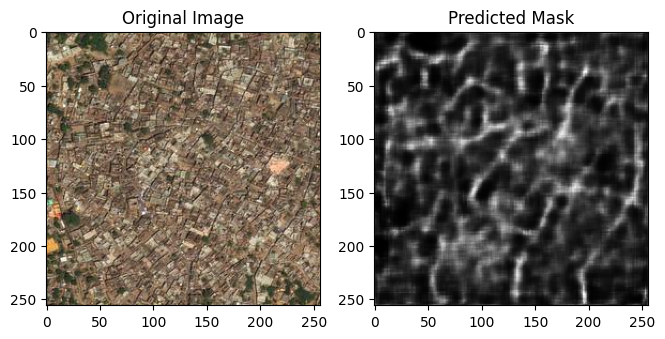

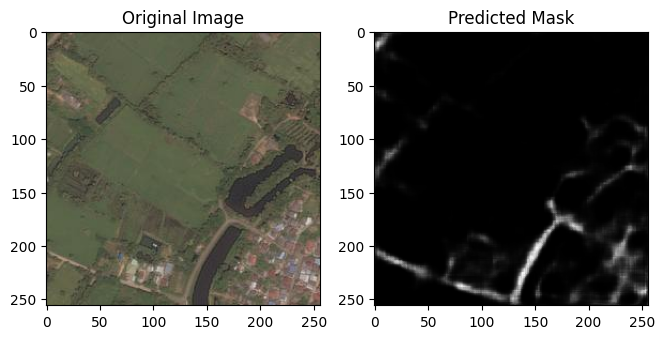

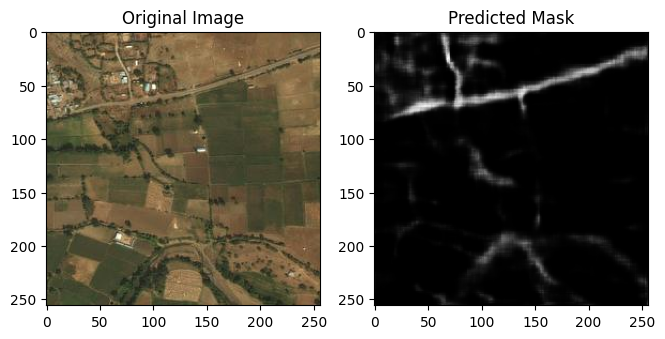

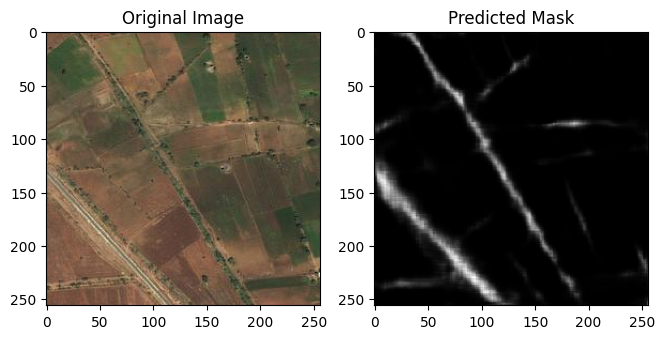

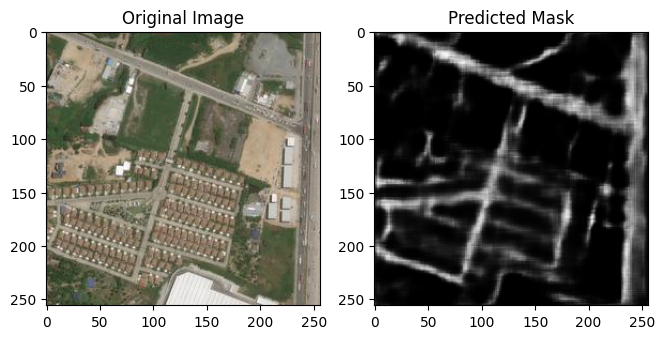

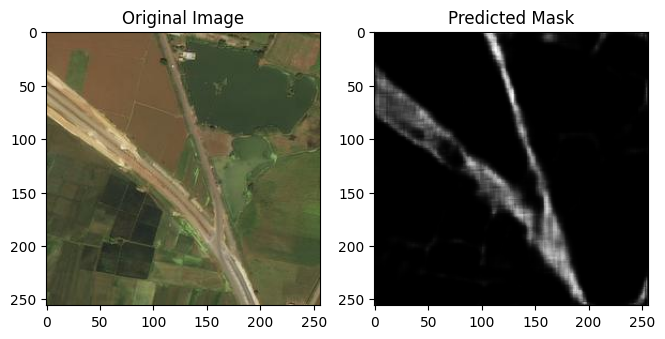

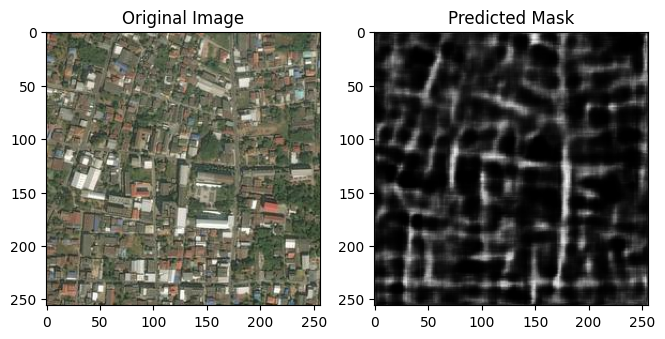

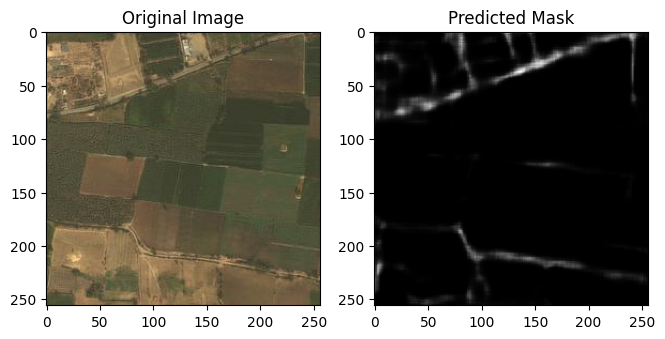

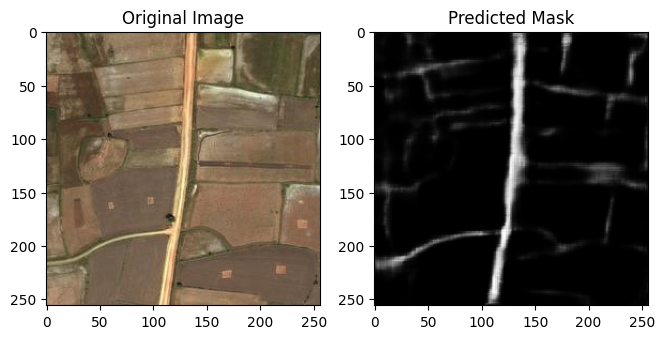

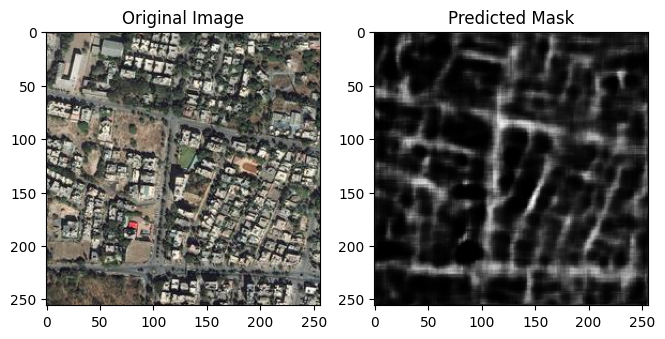

In [ ]:
##### AT 8 epochs #####
import matplotlib.pyplot as plt
import numpy as np

# Visualize some predictions
num_images_to_show = 10  # Adjust as needed

for i in range(num_images_to_show):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_gen[i][0][0])  # Get the first test image
    plt.title('Original Image')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove channels if needed
    plt.title('Predicted Mask')

    plt.show()